# Precision and Recall

## Introduction
Precision and Recall is a method for evaluating pipelines, when given ground truth. I will be demonstrating how precision and recall works in this notebook on our connectLib pipeline. 

## Simulation Data

### Easy Simulation:
Our simulated data will be a 100x100x100 volume with a voxel intensity distribution approximately the same as that of the true image volumes (i.e., 98% noise, 2% synapse). The synapse voxels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~.2 microns ^3, or about 27 voxels (assuming the synthetic data here and the real world data have identical resolutions). We will differeniate the background from the foreground in this simulation by assigning intensity values. Background voxels will be assigned a value from 0-10,000; foreground points will be given a value of 60,000. After the data goes through the pipeLine, I will gauge performance based on the following:

1. Precision: out of all the clusters the pipeline detected, how many were actually synapses? 
2. Recall: out of all the synapses in the data set, how many were actually detecte?

We believe our pipeline will yield perfect results on this simulated data. This is because the main filtering from Otsu's Binarization requires the distribution of voxel values to be bimodal. That is, there is a clear differentiation between background and foreground. 


### Easy Simulation Code

In [1]:
import sys
sys.path.insert(0,'../code/functions/')
from random import randrange as rand
from skimage.measure import label
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume

randIm = generateTestVolume()
foreground = randIm[0]
combinedIm = randIm[1]

**What We Expect Our Simulation Data Will Look Like:**
The above code should generate a 100x100x100 volume and populate it with various, non-intersectting pointsets (representing foreground synpases). When the foreground is generated, the volume will then be introduced to random background noise which will fill the rest of the volume. 

### Easy Simulation Plots

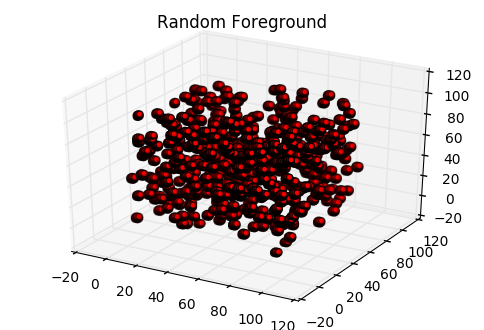

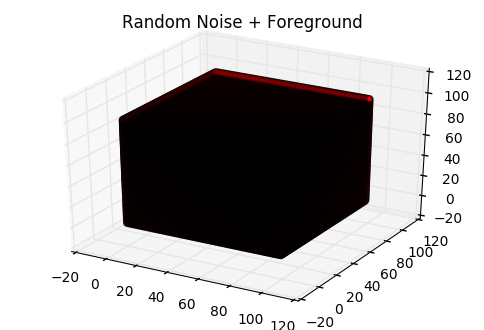

In [2]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedIm.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

**Why Our Simulation is Correct:** Real microscopic images of synapses usually contain a majority of background noise and relatively few synapse clusters. As shown above, the generated test volume follows this expectation. 

## Difficult Simulation
We will now simulate data where our algorithm will not perform well on. We will generate a 100x100x100 test volume populated with background and foreground voxels containing the same intensity. Since the distribution of voxels is now unimodal (no clear difference between background and foreground), our filtering algorithm should not work well. However, the intensity values will not appear in our matplotlib plots. Therefore, our difficult simulation will appear to be the same as the Easy Simulation, but should fail after it goes through the connectLib pipeline.

### Difficult Simulation Code and Plot

In [3]:
def generateDifficultTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = 60000
    return volume, noiseVolume

randImHard = generateDifficultTestVolume()
foregroundHard = randImHard[0]
combinedImHard = randImHard[1]

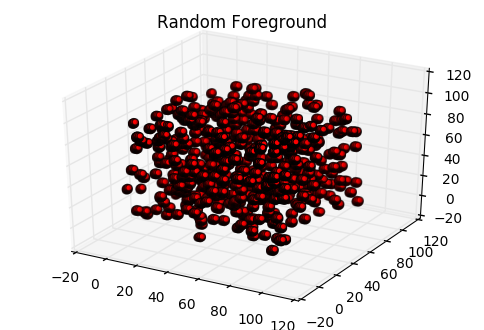

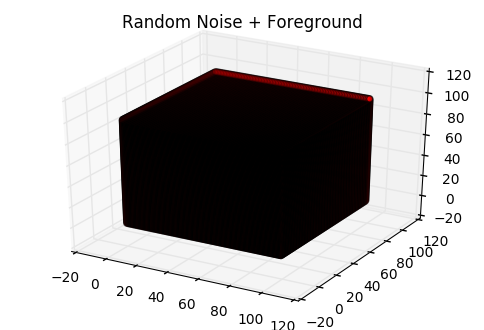

In [4]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foregroundHard.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedImHard.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

# Simulation Analysis

## Pseudocode for Precision and Recall

**Inputs: ** Two lists of synapse clusters

**Outputs: ** Precision and Recall Statistics.

In [ ]:
####Pseudocode: Will not run!####

#Step 1: Calculate True Postitives, False Negatives, and False Postitives.
FOR every synapse cluster in test volume:
    FOR every synapse cluster in true volume:
        IF test synapse cluster members == true synapse cluster members:
            True Postive Count + 1
        ELSE
            False Positive Count + 1
ENDFOR

FOR every synapse cluster in true volume:
    FOR every synapse cluster in test volume:
        IF true synapse cluster members != test synapse cluster members:
            False Negative Count + 1

#Step 2: Calculate Precision and Recall.
Precision = True Positive Count / (False Postive Count + True Postive Count)
Recall = True Positive Count / (False Negative Count + True Positive Count)

#Step 3: Generate f1 Score. 
f1 = 2*Precision*Recall/ (Precision + Recall)

## Actual Code for Precision and Recall

In [ ]:
def f1score(trueClusterList, testClusterList):
    tp = 0
    fp = 0
    fn = 0
    for testCluster in testClusterList:
        for trueCluster in trueClusterList:
            
    

## connectLib algorithm code

In [6]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from cluster import Cluster
import numpy as np
import cv2
import plosLib as pLib

### Step 1: Threshold the image using Otsu Binarization 
def otsuVox(argVox):
    probVox = np.nan_to_num(argVox)
    bianVox = np.zeros_like(probVox)
    for zIndex, curSlice in enumerate(probVox):
        #if the array contains all the same values
        if np.max(curSlice) == np.min(curSlice):
            #otsu thresh will fail here, leave bianVox as all 0's
            continue
        thresh = threshold_otsu(curSlice)
        bianVox[zIndex] = curSlice > thresh
    return bianVox

### Step 2: Cluster foreground using Connected Components
def connectedComponents(voxel):
    labelMap = label(voxel)
    clusterList = []
    #plus 1 since max label should be included
    for uniqueLabel in range(0, np.max(labelMap)+1):
        memberList = [list(elem) for elem in zip(*np.where(labelMap == uniqueLabel))]
        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))
    return clusterList

### Step 3: Remove outlier clusters using IRQ Rule
def thresholdByVolumePercentile(clusterList):
    #putting the plosPipeline clusters volumes in a list
    plosClusterVolList =[]
    for cluster in (range(len(clusterList))):
        plosClusterVolList.append(clusterList[cluster].getVolume())

    #finding the upper outlier fence
    Q3 = np.percentile(plosClusterVolList, 75)
    Q1 = np.percentile(plosClusterVolList, 25)
    IQR = Q3 - Q1
    upperThreshFence = Q3 + 1.5*IQR

    #filtering out the background cluster
    upperThreshClusterList = []
    for cluster in (range(len(clusterList))):
        if clusterList[cluster].getVolume() < upperThreshFence:
            upperThreshClusterList.append(clusterList[cluster])

    return upperThreshClusterList

### Step 4: Coregister clusters with raw data.
def clusterCoregister(plosClusterList, rawClusterList):
    #creating a list of all the member indices of the plos cluster list
    plosClusterMemberList = []
    for cluster in range(len(plosClusterList)):
        plosClusterMemberList.extend(plosClusterList[cluster].members)

    #creating a list of all the clusters without any decay
    finalClusterList =[]
    for rawCluster in range(len(rawClusterList)):
        for index in range(len(plosClusterMemberList)):
            if ((plosClusterMemberList[index] in rawClusterList[rawCluster].members) and (not(rawClusterList[rawCluster] in finalClusterList))):
                finalClusterList.append(rawClusterList[rawCluster])

    return finalClusterList

########## Complete Pipeline ##########
def completePipeline(image):
    #Plos Pipeline Results
    plosOut = pLib.pipeline(image)
    #Otsu's Binarization Thresholding
    bianOut = otsuVox(plosOut)
    #Connected Components
    connectList = connectedComponents(bianOut)
    #Remove outlier clusters
    threshClusterList = thresholdByVolumePercentile(connectList)
    #finding the clusters without plosPipeline - lists the entire clusters
    bianRawOut = otsuVox(image)
    clusterRawList = connectedComponents(bianRawOut)
    #coregistering with raw data
    clusters = clusterCoregister(threshClusterList, clusterRawList)
    return clusters

## Easy Simulation Analysis
**What We Expect**
As previously mentioned, we believe the pipeline will work very well on the easy simulation (See Simulation Data: Easy Simulation for explanation).

**Generate Easy Simulation Data:** See Simulation Data Above.

### Pipeline Run on Easy Data

In [7]:
completeClusterMemberList = completePipeline(combinedIm)

### Easy Simulation Results 

In [8]:
### Get Cluster Volumes
def getClusterVolumes(clusterList):
    completeClusterVolumes = []
    for cluster in clusterList:
        completeClusterVolumes.append(cluster.getVolume())
    return completeClusterVolumes

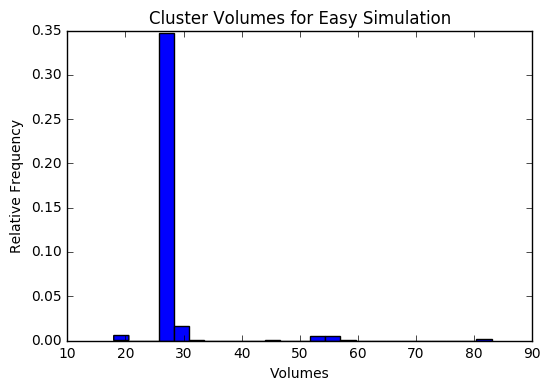

In [9]:
import mouseVis as mv

#plotting results
completeClusterVolumes = getClusterVolumes(completeClusterMemberList)
mv.generateHist(completeClusterVolumes, title = 'Cluster Volumes for Easy Simulation', bins = 25, xaxis = 'Volumes', yaxis = 'Relative Frequency')


### Performance Metrics:
We will be judging our algorithm's performance through two metrics: **average cluster volume** and **cluster density per volume**. This is based off of the 2 parameters we used to generate the test volume (see Simulation Data: Easy Simulation).

If our algorithm was successful, the average volume of detected synapse clusters should be equal to the average volume of the total foreground clusters that we generated. That is, our pipeline labeled synapses into correctly sized clusters (27 voxels). 

Cluster density basically returns how many clusters were detected given a certain volume size. This is to show how many of the synapse clusters our algorithm was actually able to label. If the algorithm performs correctly, the relative number of synapses clusters per volume should equal around 2% (the volumetric density of synapses we generated in the test volume). 

In [10]:
#test stats

# get actual cluster volumes from foreground (for 'Expected' values)
def getForegroundClusterVols(foreground):
    foregroundClusterList = connectedComponents(foreground)
    del foregroundClusterList[0] #background cluster
    foregroundClusterVols = []
    for cluster in foregroundClusterList:
        foregroundClusterVols.append(cluster.getVolume())
    return foregroundClusterVols
       
def getAverageMetric(coClusterVols, foreClusterVols):
    #no clusters found
    if (len(coClusterVols)==0):
        avgClusterVol = 0
    else:
        #average volume of detected clusters
        avgClusterVol = np.mean(coClusterVols)
    #average volume of total foreground clusters
    avgExpectedVol = np.mean(foreClusterVols)
    print 'Average Volume'
    print "\tExpected: " + str(avgExpectedVol) + '\tActual: ' + str(avgClusterVol)
    return avgExpectedVol, avgClusterVol

def getDensityMetric(coClusterVols, foreClusterVols):
    #no clusters found
    if (len(coClusterVols)==0):
        coClusterVols.append(0)
    print 'Cluster Density of Data By Volume'
    print "\tExpected: " + str(np.sum(foreClusterVols)/(100*100*100.0)) + '\tActual: ' + str(np.sum(coClusterVols)/(100*100*100.0))

### Quantify Performance for Easy Simulation

In [ ]:
foregroundClusterVols = getForegroundClusterVols(foreground)
getAverageMetric(completeClusterVolumes, foregroundClusterVols)
getDensityMetric(completeClusterVolumes, foregroundClusterVols)

As shown above, our connectLib pipeline worked extremely well on the easy simulation. The small difference between the actual and expected values come from the generated synapse point sets. Foreground synapses can potentially be adjacent to each other in the test volume. Connected Components will label the multiple, connected synapses as one cluster, which explains the cluster volumes at roughly 56 (2 synapses) and 81 (3 synapses) [See Histogram in Easy Simulation Results]. 

## Difficult Simulation Analysis
**What We Expect:** Since Otsu's Binarization depends on a bimodal distribution of voxel intensities, the background should not get thresholded for the difficult simulation. Furthermore, since all the voxels are identical in terms of intensity, connectedComponents should label the entire volume as just one cluster.

**Generate Difficult Simulation Data:** See Simulate Data: Difficult Simulation.


### Pipeline Run on Difficult Data:

In [11]:
completeClusterMemberListHard = completePipeline(combinedImHard)
print len(completeClusterMemberListHard)

/usr/local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1728: RuntimeWarning:

invalid value encountered in double_scalars



0


### Difficult Simulation Results:

In [12]:
#Plos Pipeline Results
plosOut = pLib.pipeline(combinedImHard)
#Otsu's Binarization Thresholding
bianOut = otsuVox(plosOut)
#Connected Components
connectList = connectedComponents(bianOut)
#get total volume for hard simulation clusters
totalClusterHard = []
for cluster in connectList:
    totalClusterHard.append(cluster.getVolume())
#get coregistered (complete) cluster volumes
completeClusterVolumesHard = getClusterVolumes(completeClusterMemberListHard)

print 'Number of Clusters: ' + str(len(totalClusterHard))
print 'Cluster Volume: ' + str(totalClusterHard[0])
print 'Coregistered Clusters: ' + str(len(completeClusterMemberListHard))

Number of Clusters: 1
Cluster Volume: 1000000
Coregistered Clusters: 0


### Performance Metrics
See Easy Simulation Analysis: Performance Metrics.

### Quantify Performance for Difficult Simulation

In [13]:
foregroundClusterVolsHard = getForegroundClusterVols(foregroundHard)
getAverageMetric(completeClusterVolumesHard, foregroundClusterVolsHard)
getDensityMetric(completeClusterVolumesHard, foregroundClusterVolsHard)

Average Volume
	Expected: 28.854	Actual: 0
Cluster Density of Data By Volume
	Expected: 0.014427	Actual: 0.0


As predicted, the foreground and background was combined into one cluster through the connectLib Pipeline (see Results). This large cluster does not coregister with any of the original foreground clusters. Clearly, our pipeline performed very poorly on the difficult simulation as zero clusters were actually detected. This ultimately proves our earlier thesis that the connectLib pipeline is dependent on the foreground and background voxels having significantly different intensities.

## Verify Simulation Analysis

Repeat Easy and Hard simulation analysis 10 times each. 

In [14]:
easySimulationVolumes = []
hardSimulationVolumes = []

for i in range(10):
    #Easy Simulation
    randIm = generateTestVolume()
    foreground = randIm[0]
    combinedIm = randIm[1]
    completeClusterMemberList = completePipeline(combinedIm)
    completeClusterVolumes = getClusterVolumes(completeClusterMemberList)
    foregroundClusterVols = getForegroundClusterVols(foreground)
    easySimulationVolumes.append(getAverageMetric(completeClusterVolumes, foregroundClusterVols))
    getDensityMetric(completeClusterVolumes, foregroundClusterVols)
    
    #Hard Simulation
    randImHard = generateDifficultTestVolume()
    foregroundHard = randImHard[0]
    combinedImHard = randImHard[1]
    completeClusterMemberListHard = completePipeline(combinedImHard)
    completeClusterVolumesHard = getClusterVolumes(completeClusterMemberListHard)
    foregroundClusterVolsHard = getForegroundClusterVols(foregroundHard)
    hardSimulationVolumes.append(getAverageMetric(completeClusterVolumesHard, foregroundClusterVolsHard))
    getDensityMetric(completeClusterVolumesHard, foregroundClusterVolsHard)

Average Volume
	Expected: 28.4134615385	Actual: 28.84359401
Cluster Density of Data By Volume
	Expected: 0.01773	Actual: 0.017335
Average Volume
	Expected: 27.7397260274	Actual: 0
Cluster Density of Data By Volume
	Expected: 0.014175	Actual: 0.0
Average Volume
	Expected: 28.5643879173	Actual: 28.8886986301
Cluster Density of Data By Volume
	Expected: 0.017967	Actual: 0.016871
Average Volume
	Expected: 29.0643356643	Actual: 0
Cluster Density of Data By Volume
	Expected: 0.020781	Actual: 0.0
Average Volume
	Expected: 29.8421052632	Actual: 29.8653250774
Cluster Density of Data By Volume
	Expected: 0.020412	Actual: 0.019293
Average Volume
	Expected: 28.2398703404	Actual: 0
Cluster Density of Data By Volume
	Expected: 0.017424	Actual: 0.0
Average Volume
	Expected: 28.2857142857	Actual: 28.541322314
Cluster Density of Data By Volume
	Expected: 0.014652	Actual: 0.013814
Average Volume
	Expected: 28.4954268293	Actual: 0
Cluster Density of Data By Volume
	Expected: 0.018693	Actual: 0.0
Average 

#### Plotting Expected and Average Cluster Volumes for each easy simulation. 

Red = Expected Average Volume
Blue = Observed Average Volume 

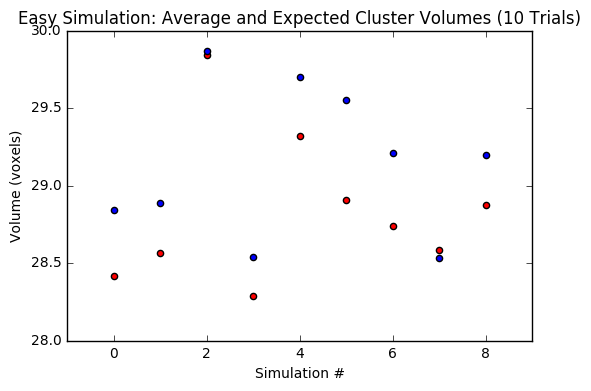

In [15]:
#separate expected and actual values into separate indices
esv = [list(t) for t in zip(*easySimulationVolumes)]
#outlier
del esv[0][6]
del esv [1][6]

fig = plt.figure()
plt.title('Easy Simulation: Average and Expected Cluster Volumes (10 Trials)')
plt.xlabel('Simulation #')
plt.ylabel('Volume (voxels)')
x = np.arange(9)
plt.scatter(x, esv[0], c='r')
plt.scatter(x, esv[1], c='b')
plt.show()

#### Plotting Expected and Average Cluster Volumes for each difficult simulation. 

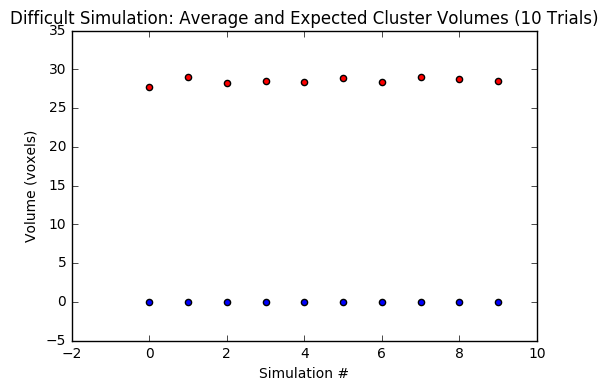

In [16]:
hsv = [list(t) for t in zip(*hardSimulationVolumes)]
fig = plt.figure()
plt.title('Difficult Simulation: Average and Expected Cluster Volumes (10 Trials)')
plt.xlabel('Simulation #')
plt.ylabel('Volume (voxels)')
x = np.arange(10)
plt.scatter(x, hsv[0], c='r')
plt.scatter(x, hsv[1], c='b')
plt.show()

## Summary of Simulation Analysis

Our difficult and easy simulation data demonstrates how our connectLib pipeline is dependent on how different the background and foreground voxel intensity values are. When the background and foreground are not distinguishable, the connectLib cannot threshold and filter out the background clusters, thus creating one large cluster combining all the voxels in the volume. Thus, essentially no synpases (clusters) can be detected correctly. On the other hand, if the foreground voxels are very distinguishable from the background noise (easy simulation), our connectLib pipeline works extremely well. For the easy simulations, 100% of the background noise was filtered out and almost all of the foreground point sets (representing synapses) were clustered correctly. The only errors were from adjacent 'synapses' that were clustered together. 

# Real Data

Our sample data will come from different slices (z = 5) of a tiff image (3D). The tiff file is a photon microscope image of a mouse brain. The dimensions of our data will be 1024 x 1024 x 5 voxels^3 (x,y,z axis respectively). 

### Displaying Real Data

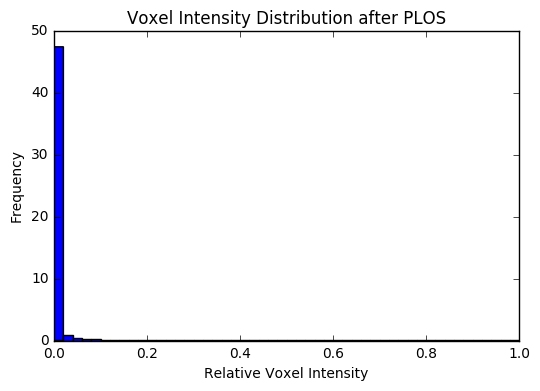

In [17]:
import pickle

realData = pickle.load(open('../data/realDataRaw_t0.synth'))
realDataSection = realData[5: 10]

plosDataSection = pLib.pipeline(realDataSection)
mv.generateHist(plosDataSection, bins = 50, title = "Voxel Intensity Distribution after PLOS", xaxis = 'Relative Voxel Intensity', yaxis = 'Frequency')

### Predicting Performance:
Mouse brains have a lot more activity than be portrayed in our simulated data. There are different captured cell types and a wide variation of background/foreground noise. Our Naive Fencing method and Otsu's Binarization could potentially not be enough to produce clean synapse clusters. Because of this added complexity present in mouse brain images, we believe our connectLib pipeline might not work perfectly on the real data. What is more concerning is that the distribution of voxel intensities is unimodal. The foreground does not appear to be significantly different from the background. Thus, Otsu's Binarization might not threshold the background successfully. 

### connectLib Algorithm Run on Real Data

In [18]:
print 'Running'
realClusterList = completePipeline(plosDataSection)
realClusterVols = getClusterVolumes(realClusterList)

Running


### Results

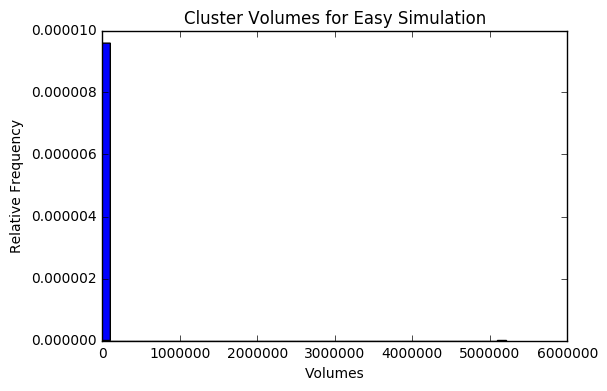

In [19]:
mv.generateHist(realClusterVols, title = 'Cluster Volumes for Easy Simulation', bins = 50, xaxis = 'Volumes', yaxis = 'Relative Frequency')

In [22]:
print realClusterVols


[5203323, 652, 28, 52, 13, 9, 9, 24, 28, 11, 2, 3, 24, 87, 20, 4, 18, 4, 4, 26, 19, 14, 14, 27, 32, 5, 35, 28, 9, 10, 23, 38, 64, 48, 42, 19, 21, 12, 10, 115, 117, 7, 41, 22, 17, 28, 22, 15, 23, 36, 95, 44, 131, 30, 9, 20, 25, 174, 13, 134, 12, 29, 7, 377, 7, 16, 21, 779, 22, 12, 28, 14, 28, 7, 21, 26, 34, 16, 11, 9, 26, 243, 9, 25, 200, 50, 13, 4, 13, 10, 15, 40, 11, 16, 58, 227, 50, 60, 10, 46, 13, 3, 44, 7, 45, 17, 13, 5, 51, 13, 9, 13, 23, 26, 56, 16, 35, 13, 12, 26, 93, 5, 9, 35, 10, 70, 41, 17, 208, 7, 29, 20, 4, 10, 55, 603, 7, 9, 89, 10, 220, 14, 9, 45, 39, 52, 6, 14, 4, 33, 17, 12, 14, 7, 50, 48, 39, 15, 8, 29, 28, 24, 66, 717, 83, 2532, 50, 6, 10, 10, 12, 21, 10, 7, 9, 7, 6, 9, 38, 15, 13, 30, 6, 169, 11, 36, 12, 22, 104, 36, 21, 40, 4, 44, 42, 7, 19, 192, 33, 34, 36, 20, 24, 19, 11, 22, 10, 12, 42, 45, 36, 8, 8, 12, 39, 12, 27, 7, 184, 6, 13, 35, 21, 15, 22, 37, 30, 12, 16, 32, 25, 18, 32, 26, 32, 12, 26, 12, 22, 17, 14, 26, 25, 4, 13, 37, 4, 13, 96, 9, 38, 16, 10, 37, 51, 3

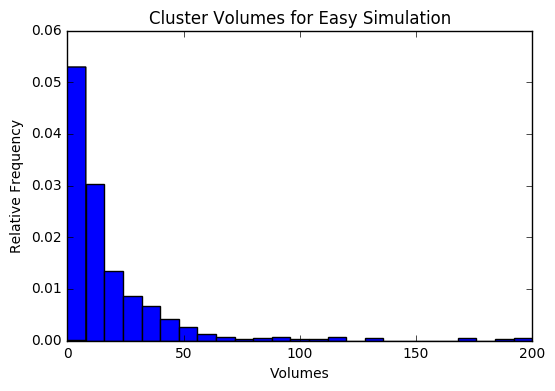

In [25]:
del realClusterVols[0]
mv.generateHist(realClusterVols, title = 'Cluster Volumes for Easy Simulation', axisStart = 0, axisEnd = 200, bins = 25, xaxis = 'Volumes', yaxis = 'Relative Frequency')

### Potential Corrections to connectLib Pipeline

Because the distribution of intensities is not clearly bimodal, a simple binary threshold, with the lower 98% of voxel intensities getting thresholded to 0, might be a better method for filtering background noise than Otsu's Method. Furthermore, there is actually more issue in filtering out additional foreground noise that are not synapses. These elements such as glial cells still get clustered and labeled as synapses but are not (as you can tell by the voxel volume). 